In [1]:
import pandas as pd
import numpy as np
import shap
import xgboost
import matplotlib.pyplot as plt
import time
import mlflow
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
import seaborn as sns
sns.set_context('paper')
# sns.set(rc={'figure.figsize':(25, 18)})

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
train = pd.read_pickle('data/train_full_features.pickle')

# Finding 1: Purchases in Recent 5 Orders

reordered                   0         1
up_num_purchases_r5                    
0.0                  0.972141  0.027859
1.0                  0.904416  0.095584
2.0                  0.756981  0.243019
3.0                  0.599216  0.400784
4.0                  0.445033  0.554967
5.0                  0.270091  0.729909


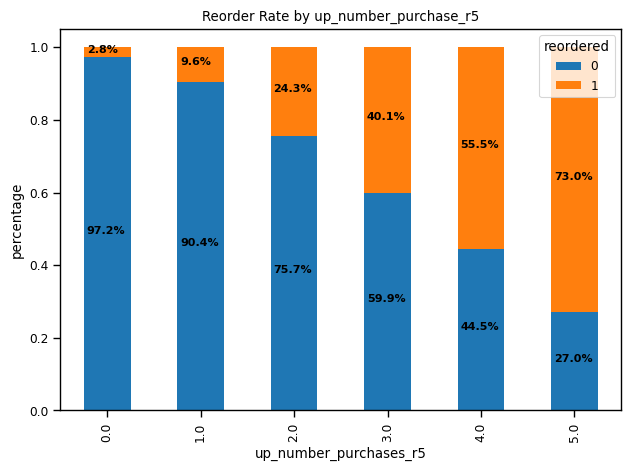

In [3]:
cross = pd.crosstab(train['up_num_purchases_r5'], train['reordered'], normalize='index')
print(cross)
cross.plot(kind='bar', stacked=True)
plt.xlabel('up_number_purchases_r5')
plt.ylabel('percentage')
plt.title('Reorder Rate by up_number_purchase_r5')
# add % on plot
for n, x in enumerate([*cross.index.values]):
    for (proportion, y_loc) in zip(cross.loc[x],
                                   cross.loc[x].cumsum()):
        plt.text(x=n - 0.22,
                 y=(y_loc - proportion) + (proportion / 2),
                 s=f'{np.round(proportion * 100, 1)}%',
                 color="black",
                 fontsize=8,
                 fontweight="bold")
plt.show()

# Finding 2: Purchases in Recent 5 Orders and Reorder Tendency

In [4]:
reorder = train.groupby(['up_reorder_tendency_proba_r5', 'up_num_purchases_r5'], dropna=False).reordered.mean().to_frame()
reorder.columns = ['reorder_rate']
reorder = reorder.reset_index().round(2)
reorder['up_reorder_tendency_proba_r5_rank'] = reorder['up_reorder_tendency_proba_r5'].rank(method='dense')-1

In [5]:
fig, ax = plt.subplots(1, 1)
g = sns.stripplot(data=train.sample(frac=0.01).round(2), x='up_reorder_tendency_proba_r5', y='up_num_purchases_r5', hue='reordered', alpha=0.7, ax=ax)
g.set_yticks([1, 2, 3, 4, 5])
# annotate
for i, j in reorder[['up_reorder_tendency_proba_r5_rank', 'up_num_purchases_r5']].values:
    if not pd.isnull(i):
        reorder_rate = reorder.loc[(reorder['up_reorder_tendency_proba_r5_rank'] == i) & (reorder['up_num_purchases_r5']==j), 'reorder_rate'].values[0]
        g.text(i, j+0.01, reorder_rate, horizontalalignment = 'center')
plt.title('Reorder Rate')
plt.savefig('images/reorder_rate_purchases_r5_and_reorder_tendency_r5.png')
plt.show()

# Finding 3: Organic Substitutes

In [ ]:
cross = pd.crosstab(train['up_organic_substitute_num_purchases_r5'].astype(int), train['reordered'], normalize='index')
cross.sort_index(ascending=False, inplace=True)
print(cross)

reordered                                      0         1
up_organic_substitute_num_purchases_r5                    
5                                       0.942882  0.057118
4                                       0.914337  0.085663
3                                       0.899602  0.100398
2                                       0.882357  0.117643
1                                       0.872731  0.127269
0                                       0.902376  0.097624


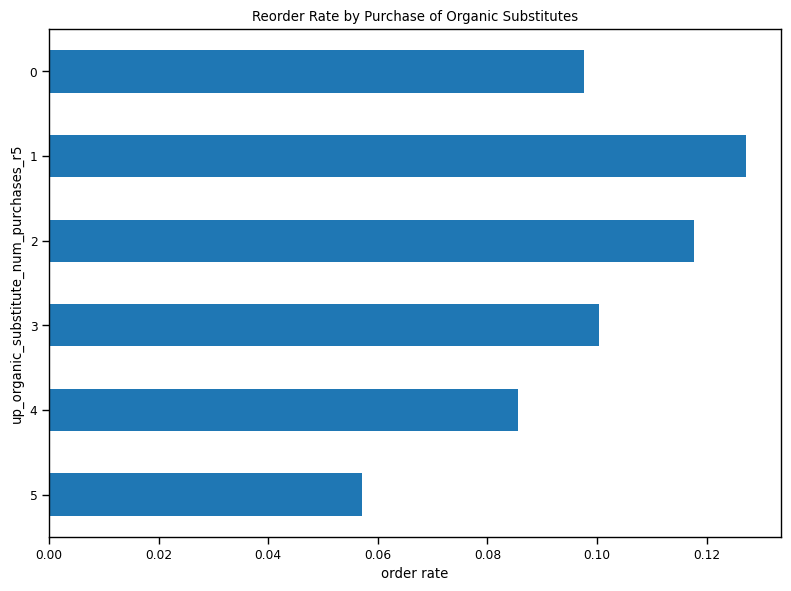

In [ ]:
cross[[1]].plot(kind='barh', legend=None, figsize=(8, 6))
# sns.barplot(x=1, y='up_organic_substitute_num_purchases_r5', data=cross[1].reset_index())
plt.ylabel('up_organic_substitute_num_purchases_r5')
plt.xlabel('order rate')
plt.title('Reorder Rate by Purchase of Organic Substitutes')
plt.savefig('images/Reorder Rate by Purchase of Organic Substitutes')
plt.show()

# Finding 4: Reorder Rate by Overdue Days

<Figure size 1000x2200 with 0 Axes>

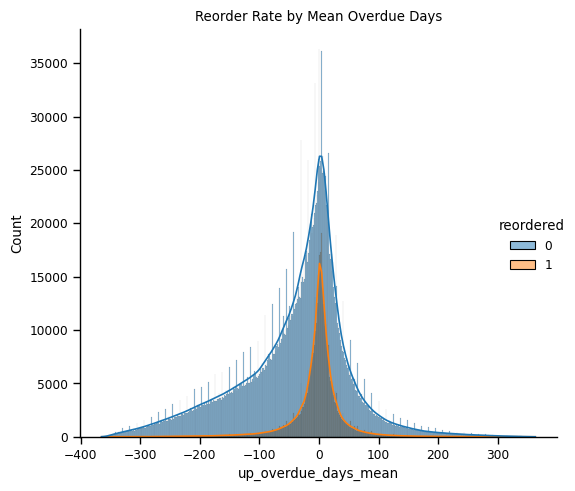

In [ ]:
plt.figure(figsize=(10, 22))
sns.displot(x='up_overdue_days_diff_mean_vs_self', data=train, hue='reordered', kde=True)
plt.title('Reorder Rate by Mean Overdue Days')
plt.tight_layout()
plt.savefig('images/Reorder Rate by Mean Overdue Days')
plt.show(block=True);

In [ ]:
train.loc[train['reordered']==0, 'up_overdue_days_diff_mean_vs_self'].describe().round(decimals = 2)

count    840902.00
mean         39.03
std          92.23
min        -363.00
25%         -13.17
50%          19.00
75%          84.00
max         364.00
Name: up_overdue_days_diff_mean_vs_self, dtype: float64

In [ ]:
train.loc[train['reordered']==1, 'up_overdue_days_diff_mean_vs_self'].describe().round(decimals = 2)

count    177193.00
mean          2.04
std          44.80
min        -361.00
25%         -13.00
50%          -1.00
75%          13.00
max         362.00
Name: up_overdue_days_diff_mean_vs_self, dtype: float64